# Actividad evaluable del módulo 3: Clasificación del conjunto de datos MNIST

Ahora que hemos aprendido a utilizar todo lo que nos ofrece PyTorch, vamos a clasificar un conjunto de datos específico. Más concretamente, construiremos un clasificador para el conjunto de datos MNIST de cifras escritas a mano (https://en.wikipedia.org/wiki/MNIST_database). Este conjunto contiene decenas de miles de cifras entre 0 y 9 escritas a mano, y se suele utilizar a menudo para entrenar algoritmos de *machine learning*. En esta actividad, le proporcionaremos código básico para cargar los datos y deberá construir una red neuronal profunda entrenada con este conjunto de datos. Le animamos a reutilizar el código que haya escrito o visto en los cuadernos anteriores.

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time, copy

# Configuración del dispositivo (si es posible, entrene el modelo con la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Primero, cargaremos el conjunto de datos MNIST. PyTorch ofrece una serie de funciones integradas para cargar conjuntos de imágenes de uso frecuente, entre ellos MNIST.

In [ ]:
# Estas transformaciones se aplicarán a todos los puntos de datos. En este ejemplo, queremos transformarlos
# todos al tipo de datos Tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# Vamos a dividir el conjunto de datos de entrenamiento en entrenamiento y validación
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 9105070.88it/s] 


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1427645.18it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8697199.64it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6772317.37it/s]


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [ ]:
# Crearemos DataLoaders, igual que hicimos antes, y el tamaño de los lotes será de 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 50000, 'val': 10000, 'test': 10000}


In [ ]:
# Una pista: En el cuaderno "Módulo 3: Introducción a PyTorch",
# la red que creamos requería que los datos de input tuvieran la forma Nx1, donde N es el número de atributos.
# El conjunto de datos MNIST tiene una forma de 28 x 28, porque se trata de imágenes.
# Utilice este fragmento de código a medida que vaya iterando los puntos de datos del conjunto
# para aplanarlos, de manera que tengan un tamaño de 784 x 1 y se puedan utilizar con los modelos que ya hemos diseñado.

# Este bucle solo itera por los puntos de datos de entrenamiento.
# En el cuaderno anterior
phases = ["train", "val", "test"]
for phase in phases:
  for inputs, labels in dataloaders[phase]:
    # Esto aplanará todos los lotes para que tengan el tamaño correcto
    inputs = inputs.view(inputs.shape[0],-1)

print("inputs", inputs)

inputs tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])


In [ ]:
# ESCRIBA AQUÍ SU CÓDIGO

# Definimos una red neuronal simple
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


model = SimpleNN().to(device)
#model = SimpleNN()


# pérdida y optimizador ("loss and optimizer") =
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# planificador
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
# Extraído de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Los mejores pesos se deben guardar por separado
    best_acc = 0.0
    best_epoch = 0

    # Cada ciclo tiene una fase de entrenamiento, una de validación y una de prueba
    phases = ['train', 'val', 'test']

    # Hacer un seguimiento de la evolución de la pérdida y la precisión durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en el modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en el modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Iterar con los datos
            for inputs, labels in dataloaders[phase]:
                # Importante: se deben aplanar todos los puntos de datos
                # para que sean compatibles con el modelo
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a 0 los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Hacer una copia profunda del modelo si se ha alcanzado la mejor precisión
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)

    return model, training_curves


model, training_curves = train_model(model, dataloaders, dataset_sizes,criterion, optimizer, scheduler, num_epochs=20)
print("trainingcurve",training_curves)


Epoch 1/20
----------
train Loss: 0.5726 Acc: 0.8212
val   Loss: 0.2648 Acc: 0.9208
test  Loss: 0.2514 Acc: 0.9243

Epoch 2/20
----------
train Loss: 0.2866 Acc: 0.9139
val   Loss: 0.1850 Acc: 0.9442
test  Loss: 0.1767 Acc: 0.9462

Epoch 3/20
----------
train Loss: 0.2238 Acc: 0.9326
val   Loss: 0.1547 Acc: 0.9510
test  Loss: 0.1467 Acc: 0.9555

Epoch 4/20
----------
train Loss: 0.1949 Acc: 0.9403
val   Loss: 0.1520 Acc: 0.9530
test  Loss: 0.1437 Acc: 0.9561

Epoch 5/20
----------
train Loss: 0.1777 Acc: 0.9472
val   Loss: 0.1370 Acc: 0.9585
test  Loss: 0.1320 Acc: 0.9588

Epoch 6/20
----------
train Loss: 0.1664 Acc: 0.9494
val   Loss: 0.1134 Acc: 0.9644
test  Loss: 0.1171 Acc: 0.9628

Epoch 7/20
----------
train Loss: 0.1535 Acc: 0.9542
val   Loss: 0.1045 Acc: 0.9664
test  Loss: 0.0994 Acc: 0.9673

Epoch 8/20
----------
train Loss: 0.1219 Acc: 0.9621
val   Loss: 0.0942 Acc: 0.9694
test  Loss: 0.0910 Acc: 0.9721

Epoch 9/20
----------
train Loss: 0.1157 Acc: 0.9652
val   Loss: 0.0920

In [ ]:
# Aquí tiene algunas funciones de utilidad para representar gráficamente los resultados.
from sklearn import metrics
import matplotlib.pyplot as plt
def plot_training_curves(training_curves,
                         phases,
                         metrics):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                # Convertir los tensores a CPU antes de graficar
                data = training_curves[key]
                if torch.is_tensor(data):
                    data = data.cpu().numpy()


                plt.plot(epochs,data,label=phase)
        plt.xlabel('epoch')
        plt.ylabel(metric)
        plt.legend(labels=phases)
        plt.show()

def classify_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en el modo de evaluación
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Importante: Se deben aplanar todos los puntos de datos
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


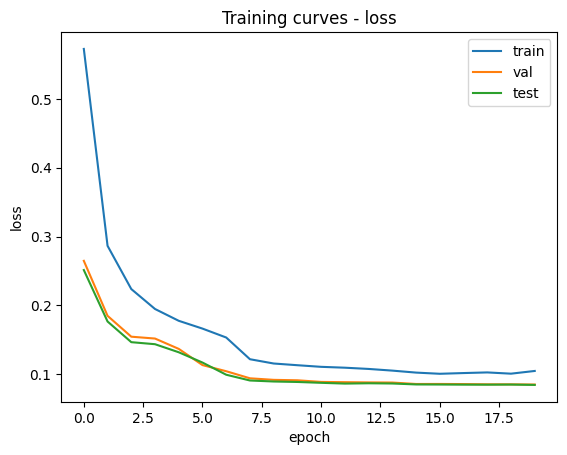

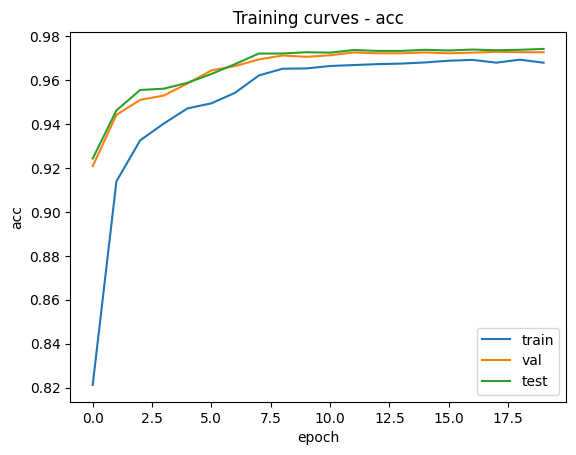

In [ ]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'],metrics=['loss','acc'])

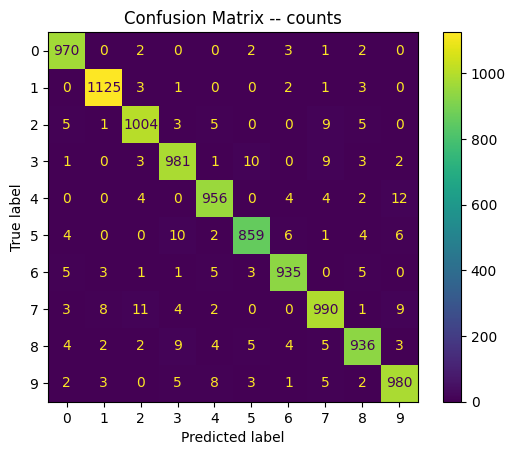

In [ ]:
res = plot_cm(model, device, dataloaders, phase='test')